2/24/24

This Notebook uses a lot of code from calcSimSystamatics (same directory), but compares a simulation and measurement from a monopole drive

- VNA is calibrated at end of chode cable. IE chode cable is calibrated out and refrence plane at at the bicon's port
- port 1 is bicon, 2 is monopole (both simulation and measurement). This was flipped for a sigle lab book entry on 2/23/24, but is now consistant
- data and calibration are saved in this directory. There are some notes in google doc lab book on 2_24_24


In [27]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

In [28]:
#pack df of measured data (from amin) from CSVs

import os
import pandas as pd

# Directory containing the CSV files
data_dir_new = '/drBigBoy/darkRadio/comsolSimulations/run1A_simulation_10_3_23/monopoleDriveSimValidation/data_2_24_24/'

# List of file indices to ignore
bad_data_idx = []

# Columns to extract from the CSV
columns_to_extract = ['Frequency', 'S11_Magnitude', 'S11_Phase', 'S22_Magnitude', 'S22_Phase', 'S12_Magnitude', 'S12_Phase']

# Initialize an empty DataFrame to hold the data
df_meas = pd.DataFrame()

# List all files in the directory that match the pattern and are not in the bad data index
for filename in os.listdir(data_dir_new):
    if filename.startswith('sParamData_p') and filename.endswith('.csv'):
        # Extract index from the filename and check if it's not in the bad data list
        file_idx = int(filename.split('p')[-1].split('.')[0])  # Extract the number after 'p'
        if file_idx not in bad_data_idx:
            # Construct full file path
            file_path = os.path.join(data_dir_new, filename)
            # Read the CSV file
            temp_df = pd.read_csv(file_path, usecols=columns_to_extract)
            # Add the index column
            temp_df['Index'] = file_idx
            # Append to the main DataFrame
            df_meas = pd.concat([df_meas, temp_df], ignore_index=True)

#VNA has glitch at 62.00MHz. Replace it with average of two adjacent bins
# Filter rows for the frequencies 61928888 and 62071111 across all indexes
adjacent_freqs_df = df_meas[df_meas['Frequency'].isin([61928888, 62071111])]

# Calculate the average for each S parameter for these frequencies by Index
avg_s_params = adjacent_freqs_df.groupby('Index').mean().drop(columns=['Frequency'])

# Replace the S parameters for frequency 62000000 Hz with the calculated averages
for idx, row in avg_s_params.iterrows():
    df_meas.loc[(df_meas['Frequency'] == 62000000) & (df_meas['Index'] == idx), ['S11_Magnitude', 'S11_Phase', 'S12_Magnitude', 'S12_Phase', 'S22_Magnitude', 'S22_Phase']] = row.values


df_meas['S11_Magnitude_Linear'] = 10 ** (df_meas['S11_Magnitude'] / 20.0)
df_meas['S22_Magnitude_Linear'] = 10 ** (df_meas['S22_Magnitude'] / 20.0)
df_meas['S12_Magnitude_Linear'] = 10 ** (df_meas['S12_Magnitude'] / 20.0)

# Now combined_df contains all the data from the CSV files excluding the bad indices
df_meas  # Show the first few rows of the DataFrame


,Frequency,S11_Magnitude,S11_Phase,S12_Magnitude,S12_Phase,S22_Magnitude,S22_Phase,Index,S11_Magnitude_Linear,S22_Magnitude_Linear,S12_Magnitude_Linear
0,30000000,-0.618858,-111.386332,-62.954829,-98.668651,0.078723,-8.863799,8,0.931230,1.009104,0.000712
1,30071111,-0.550007,-112.021716,-76.029575,47.294815,0.036788,-8.786781,8,0.938641,1.004244,0.000158
2,30142222,-0.545370,-112.748676,-76.620454,48.545765,0.036914,-8.800341,8,0.939143,1.004259,0.000148
3,30213333,-0.540811,-113.470659,-76.205563,38.262459,0.036941,-8.806801,8,0.939636,1.004262,0.000155
4,30284444,-0.539380,-114.201313,-77.099415,52.980421,0.037063,-8.819466,8,0.939790,1.004276,0.000140
...,...,...,...,...,...,...,...,...,...,...,...
67510,349715555,-4.984659,-76.706198,-16.501542,-96.551899,-4.761808,-11.622913,6,0.563335,0.577976,0.149597
67511,349786666,-4.864456,-75.516768,-16.221133,-108.475177,-3.798938,-10.539859,6,0.571186,0.645733,0.154505
67512,349857777,-4.555791,-75.039242,-16.183063,-119.873153,-3.074265,-11.663687,6,0.591848,0.701919,0.155184
67513,349928888,-4.196861,-75.961618,-16.304708,-130.312890,-2.607291,-13.626580,6,0.616818,0.740688,0.153026


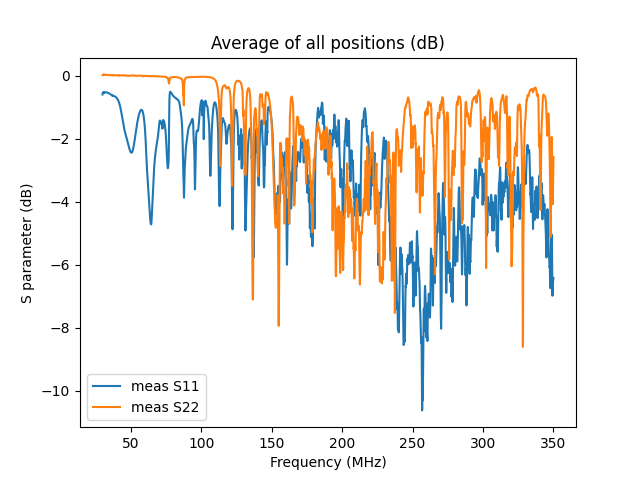

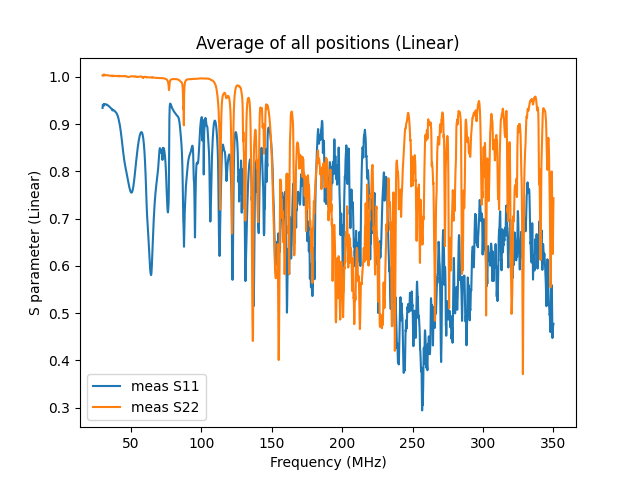

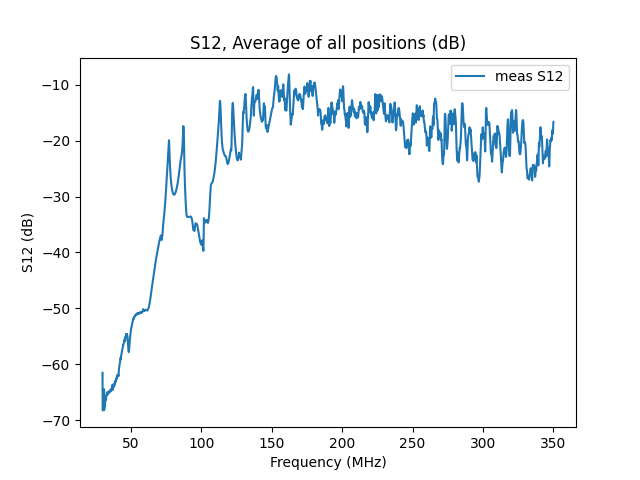

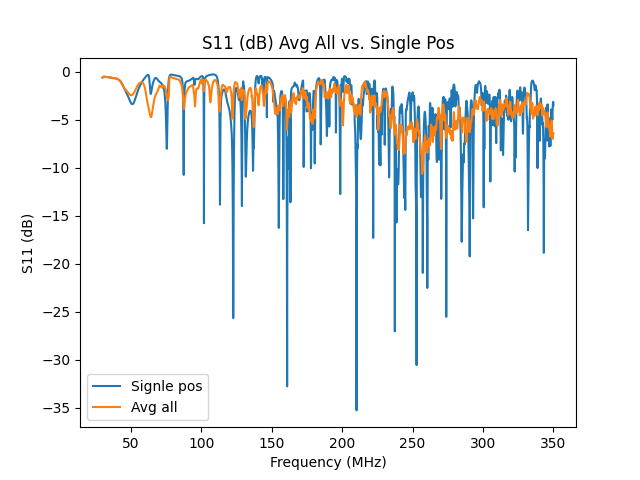

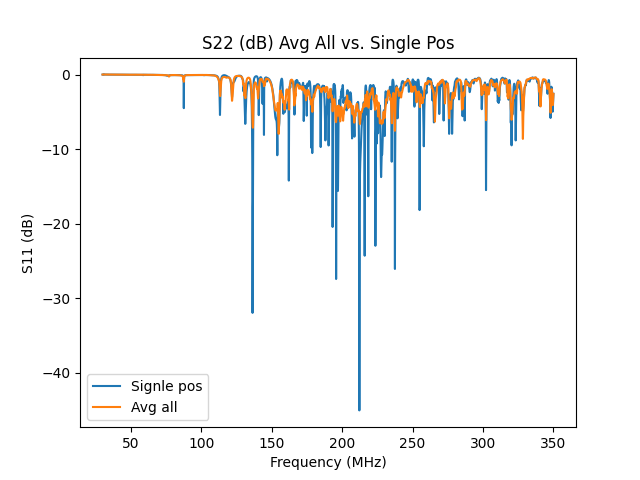

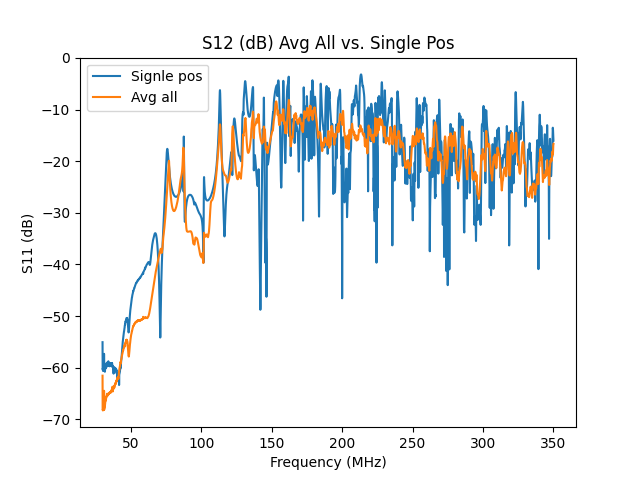

In [29]:
plt.close('all')

measured_s11_mean_all   = df_meas.groupby('Frequency')['S11_Magnitude_Linear'].mean()
measured_s22_mean_all   = df_meas.groupby('Frequency')['S22_Magnitude_Linear'].mean()
measured_s12_mean_all   = df_meas.groupby('Frequency')['S12_Magnitude_Linear'].mean()

measured_s11_pos0   = df_meas[df_meas['Index'] == 0].groupby('Frequency')['S11_Magnitude_Linear'].mean()
measured_s22_pos0   = df_meas[df_meas['Index'] == 0].groupby('Frequency')['S22_Magnitude_Linear'].mean()
measured_s12_pos0   = df_meas[df_meas['Index'] == 0].groupby('Frequency')['S12_Magnitude_Linear'].mean()


measured_freqs      = df_meas['Frequency'].unique()/1e6
#simulated_mean_all  = df_comsol.groupby('freq(MHz)')['s11'].mean()
#simulated_freqs     =df_comsol['freq(MHz)'].unique()

#filtered_df = df_comsol[df_comsol['positionIdx'].isin([0,2,4,6,8,10,12,14,16])]
#simulated_mean_9pos = filtered_df.groupby('freq(MHz)')['s11'].mean()

# Interpolate the simulated average onto the measured frequencies
#measured_interpolated_all = np.interp(simulated_freqs, measured_freqs, measured_mean_all, )

plt.figure()
plt.title("Average of all positions (dB)")
plt.plot(measured_freqs, 20*np.log10(measured_s11_mean_all), label = 'meas S11')
plt.plot(measured_freqs, 20*np.log10(measured_s22_mean_all), label = 'meas S22')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S parameter (dB)')
plt.legend()

plt.figure()
plt.title("Average of all positions (Linear)")
plt.plot(measured_freqs, measured_s11_mean_all, label = 'meas S11')
plt.plot(measured_freqs, measured_s22_mean_all, label = 'meas S22')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S parameter (Linear)')
plt.legend()

plt.figure()
plt.title("S12, Average of all positions (dB)")
plt.plot(measured_freqs, 20*np.log10(measured_s12_mean_all), label = 'meas S12')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S12 (dB)')
plt.legend()

plt.figure()
plt.title("S11 (dB) Avg All vs. Single Pos")
plt.plot(measured_freqs, 20*np.log10(measured_s11_pos0), label = 'Signle pos')
plt.plot(measured_freqs, 20*np.log10(measured_s11_mean_all), label = 'Avg all')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S11 (dB)')
plt.legend()

plt.figure()
plt.title("S22 (dB) Avg All vs. Single Pos")
plt.plot(measured_freqs, 20*np.log10(measured_s22_pos0), label = 'Signle pos')
plt.plot(measured_freqs, 20*np.log10(measured_s22_mean_all), label = 'Avg all')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S11 (dB)')
plt.legend()

plt.figure()
plt.title("S12 (dB) Avg All vs. Single Pos")
plt.plot(measured_freqs, 20*np.log10(measured_s12_pos0), label = 'Signle pos')
plt.plot(measured_freqs, 20*np.log10(measured_s12_mean_all), label = 'Avg all')
plt.xlabel('Frequency (MHz)')
plt.ylabel('S11 (dB)')
plt.legend()

In [30]:
###bootstrap measured data

n_pos_avg = 9 #num antenna positions
s11_samples = []
    
plt.close('all')
#plt.figure()

for i in range(1000):
    # Randomly select 9 positions from measured and simulated datasets
    measured_positions = np.random.choice(df_meas['Index'].unique(), n_pos_avg, replace=True)
    #simulated_positions = np.random.choice(df_comsol['positionIdx'].unique(), n_pos_avg, replace=True)

    # Get all frequency points for the selected measured positions
    measured_sample = df_meas[df_meas['Index'].isin(measured_positions)]
    # Group by frequency and calculate mean S11_Magnitude for the measured data
    measured_mean = measured_sample.groupby('Frequency')['S11_Magnitude_Linear'].mean()




    s11_samples.append(measured_mean)

# Convert list of arrays into a 2D numpy array
s11_samples_array = np.vstack(s11_samples)

In [ ]:
##### only plot median and 95% #####

# Define the list of percentiles to calculate


# Calculate median
median_s11 = np.percentile(delta_s11_samples_array, 50 , axis=0)

# 63% s11
upper_63_s11 = np.percentile(delta_s11_samples_array, (100-63)/2 , axis=0)
lower_63_s11 = np.percentile(delta_s11_samples_array, 100-(100-63)/2 , axis=0)

# 95% s11
upper_95_s11 = np.percentile(delta_s11_samples_array, (100-95)/2 , axis=0)
lower_95_s11 = np.percentile(delta_s11_samples_array, 100-(100-95)/2 , axis=0)


plt.figure(figsize=(10, 6))

plt.xlabel('Frequency (MHz)')
plt.ylabel('(S11_meas - S11_sim)/mean(S11_mean, S11_sim)')
plt.title('S11 Distribution by Percentile')
plt.plot(simulated_freqs, median_s11, 'r', linewidth = 3, label = 'Median')
plt.plot(simulated_freqs, upper_63_s11, 'g', label = '63% CL', alpha = .5)
plt.plot(simulated_freqs, lower_63_s11, 'g', alpha = .5)
plt.plot(simulated_freqs, upper_95_s11,'b', label = '95% CL', alpha = .5)
plt.plot(simulated_freqs, lower_95_s11,'b', alpha = .5)
plt.legend()
plt.grid(True)
plt.show()

